In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
#!unzip archive.zip

In [3]:
DATA_DIR = '/kaggle/input/ffhq-face-data-set'

# Часть 1. Подготовка данных

In [4]:
image_size = 64
batch_size = 128

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def get_dataloader(image_size, batch_size, stats):
    
    """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
    
    return DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True), train_ds

In [5]:
train_loader, train_ds = get_dataloader(image_size, batch_size, stats)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

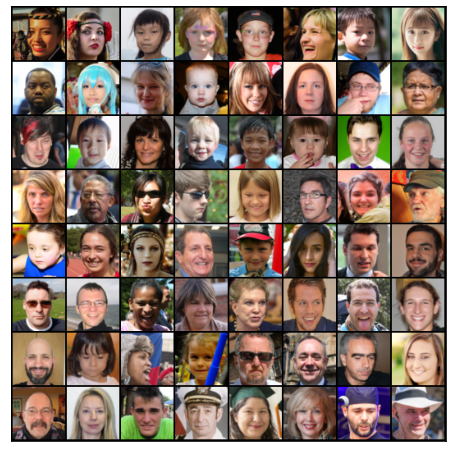

In [8]:
show_batch(train_loader)

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_loader, device)

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Часть 2. Построение и обучение модели 

In [13]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
   

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    
    nn.Linear(512, 256, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Linear(256, 1, bias=False),
    
  #  nn.Sigmoid()
)

In [15]:
discriminator = to_device(discriminator, device)
latent_size = 100

In [16]:


generator = nn.Sequential(
    # in: latent_size x 1 x 1
   
    #nn.Linear(latent_size, latent_size)
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.SiLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.SiLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.SiLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.SiLU(True),
    # out: 64 x 32 x 32
    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [17]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

# Print the model
print(generator)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): SiLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): SiLU(inplace=True)
  (9): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): SiLU(inplace=True)
  (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)


In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

torch.Size([128, 3, 64, 64])


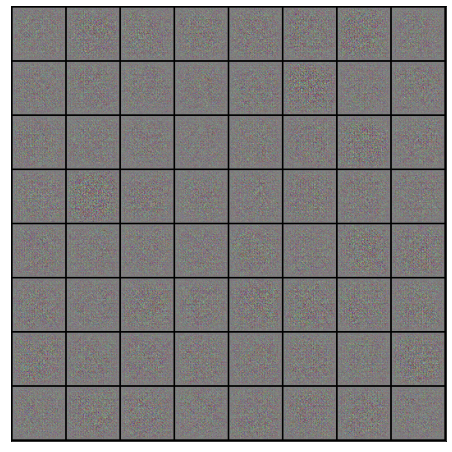

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator = to_device(generator, device)

In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
 fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [23]:
lr = 2e-04
epochs = 40
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCEWithLogitsLoss(),
    "generator": nn.BCEWithLogitsLoss()
}

In [24]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    sigm = nn.Sigmoid()
   # tanh = nn.Tanh()
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, weight_decay = 0.0002/epochs, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, weight_decay = 0.0002/epochs, betas=(0.5, 0.999))
    }
    min_loss_g =np.inf
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_logits = model["discriminator"](real_images)
           
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_logits, real_targets)
            real_preds = sigm(real_logits)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_logits = model["discriminator"](fake_images)
            
            fake_loss = criterion["discriminator"](fake_logits, fake_targets)
            fake_preds = sigm(fake_logits)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            logits = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](logits, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        #if losses_g[-1] < min_loss_g:
         #   min_loss_g = losses_g[-1]
          #  torch.save(generator.state_dict(), 'generator_weights.pth')
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
            
    torch.save(generator.state_dict(), 'generator_weights.pth')
    
    return losses_g, losses_d, real_scores, fake_scores

In [25]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 4.9984, loss_d: 0.5210, real_score: 0.8558, fake_score: 0.1472


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 3.1741, loss_d: 0.5929, real_score: 0.8235, fake_score: 0.1788


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 3.0388, loss_d: 0.6278, real_score: 0.8097, fake_score: 0.1900


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 2.8183, loss_d: 0.6227, real_score: 0.8073, fake_score: 0.1943


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 2.6189, loss_d: 0.6607, real_score: 0.7949, fake_score: 0.2053


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 2.5099, loss_d: 0.6664, real_score: 0.7916, fake_score: 0.2092


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 2.6203, loss_d: 0.6361, real_score: 0.8019, fake_score: 0.1993


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 2.5703, loss_d: 0.6466, real_score: 0.7998, fake_score: 0.2002


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 2.5645, loss_d: 0.6402, real_score: 0.8029, fake_score: 0.1976


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 2.5972, loss_d: 0.6158, real_score: 0.8094, fake_score: 0.1917


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 2.6656, loss_d: 0.5990, real_score: 0.8144, fake_score: 0.1861


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 2.6616, loss_d: 0.5990, real_score: 0.8161, fake_score: 0.1850


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 2.7535, loss_d: 0.5742, real_score: 0.8224, fake_score: 0.1773


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 2.7461, loss_d: 0.5956, real_score: 0.8203, fake_score: 0.1811


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 2.7920, loss_d: 0.5652, real_score: 0.8259, fake_score: 0.1746


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 2.8644, loss_d: 0.5672, real_score: 0.8280, fake_score: 0.1724


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 2.8794, loss_d: 0.5908, real_score: 0.8252, fake_score: 0.1745


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 3.0821, loss_d: 0.5004, real_score: 0.8457, fake_score: 0.1552


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 3.1560, loss_d: 0.5132, real_score: 0.8448, fake_score: 0.1554


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 3.1440, loss_d: 0.5088, real_score: 0.8461, fake_score: 0.1545


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 3.1624, loss_d: 0.5239, real_score: 0.8433, fake_score: 0.1568


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 3.3638, loss_d: 0.4741, real_score: 0.8581, fake_score: 0.1423


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 3.6119, loss_d: 0.4187, real_score: 0.8714, fake_score: 0.1295


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 3.5559, loss_d: 0.4483, real_score: 0.8663, fake_score: 0.1345


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 3.7156, loss_d: 0.4714, real_score: 0.8677, fake_score: 0.1312


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 3.5451, loss_d: 0.4402, real_score: 0.8657, fake_score: 0.1355


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 3.8498, loss_d: 0.3957, real_score: 0.8800, fake_score: 0.1204


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 3.8618, loss_d: 0.4172, real_score: 0.8763, fake_score: 0.1242


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 3.9749, loss_d: 0.4010, real_score: 0.8806, fake_score: 0.1194


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 3.7439, loss_d: 0.5075, real_score: 0.8613, fake_score: 0.1382


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 4.1525, loss_d: 0.3734, real_score: 0.8869, fake_score: 0.1133


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 4.2327, loss_d: 0.3602, real_score: 0.8921, fake_score: 0.1082


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 4.3128, loss_d: 0.3767, real_score: 0.8903, fake_score: 0.1095


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 4.2112, loss_d: 0.3860, real_score: 0.8879, fake_score: 0.1122


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 4.4697, loss_d: 0.3459, real_score: 0.8980, fake_score: 0.1015


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 4.6919, loss_d: 0.3153, real_score: 0.9055, fake_score: 0.0947


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.5898, loss_d: 0.3545, real_score: 0.8985, fake_score: 0.1020


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 4.6248, loss_d: 0.3447, real_score: 0.8994, fake_score: 0.1002


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 4.7761, loss_d: 0.3332, real_score: 0.9045, fake_score: 0.0956


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 4.8778, loss_d: 0.3135, real_score: 0.9076, fake_score: 0.0923
Saving generated-images-0040.png


In [26]:
losses_g, losses_d, real_scores, fake_scores = history

# Часть 3. Генерация изображений 

In [27]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

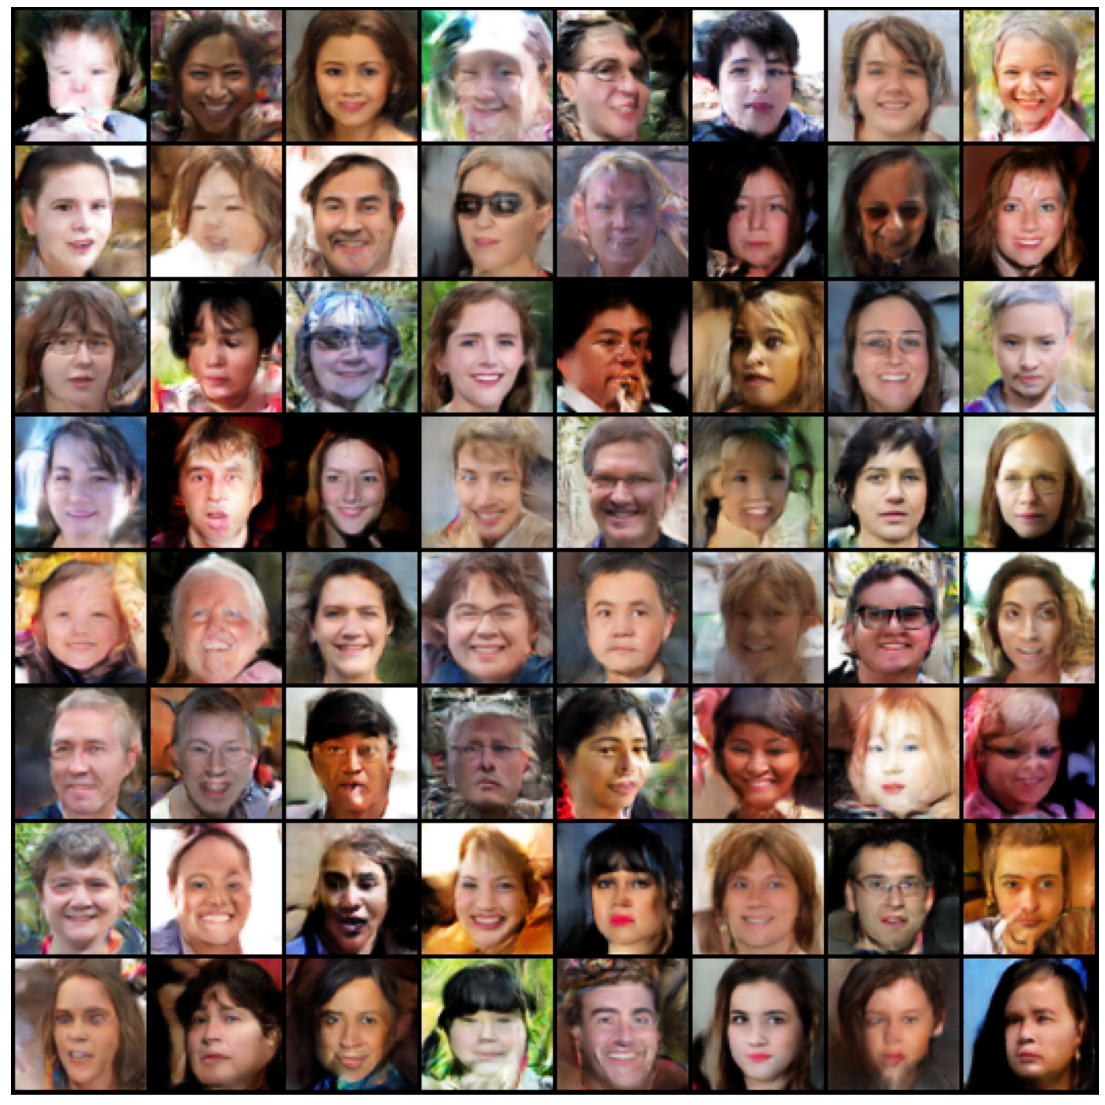

In [28]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

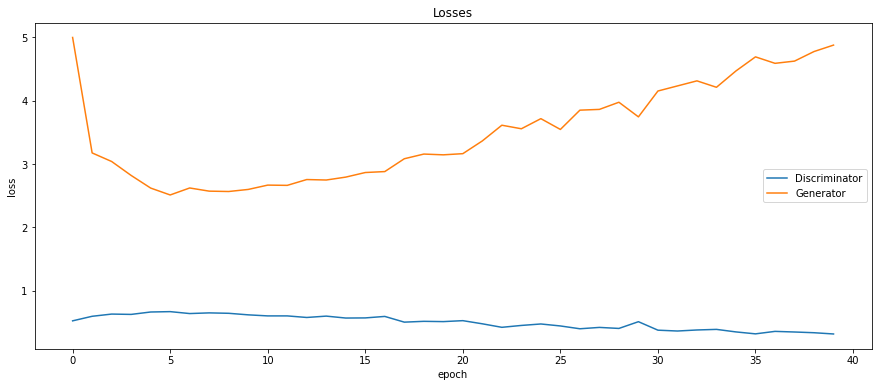

In [29]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

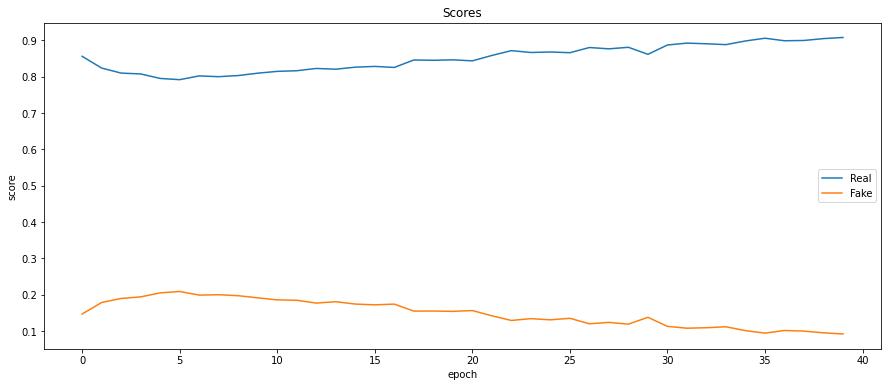

In [30]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

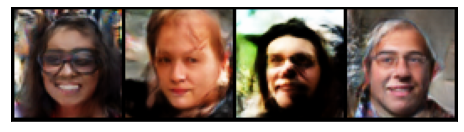

In [31]:
best_generator = model['generator']
best_generator.load_state_dict(torch.load('/kaggle/working/generator_weights.pth'))
best_generator.to('cpu')
best_generator.eval()

fixed_latent = torch.randn(4, latent_size, 1, 1)
fake_images = best_generator(fixed_latent)

show_images(fake_images.cpu())

# Часть 4. Leave-one-out-1-NN classifier accuracy

4.1. Подсчет accuracy (4 балла)

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.manifold import TSNE
import plotly.express as px

In [33]:
samples = torch.randn(3500, latent_size, 1, 1)
fake_samples = best_generator(samples)
fake_labels = torch.zeros(3500, 1)

true_samples = [i[0] for i in tqdm(train_ds)][:3500]
true_samples = torch.stack(true_samples).to('cpu')
true_labels = torch.ones(3500, 1)

all_labels = torch.cat((fake_labels, true_labels))
all_samples = torch.cat((fake_samples, true_samples))

  0%|          | 0/70000 [00:00<?, ?it/s]

In [34]:
X = all_samples.view(3500*2, -1).cpu().detach().numpy()
y = all_labels.detach().numpy().ravel()

In [35]:
%%time
scores = cross_val_score(KNeighborsClassifier(n_neighbors=1),
                X,
                y,
                scoring = 'accuracy',        
                cv=LeaveOneOut())
scores.mean()

CPU times: user 1h 24min 18s, sys: 21min 36s, total: 1h 45min 54s
Wall time: 1h 3min 46s


0.5887142857142857

точность нашей классификации должно стримиться к 0.5

 4.2. Визуализация распределений (2 балла)

In [36]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [37]:
fig = px.scatter(tsne_results, x=0, y=1, color=y.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

в целом распределения фейков и реальных изображений похожи